In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [87]:
#Read in our data set
train_original = pd.read_csv('../input/train.csv')
real_test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [88]:
#Let's take a look at it
train_original.head()
train_original.info()

#A lot of these fields are mainly null. Let's go ahead and remove them

train = train_original.drop(['MiscFeature', 'Fence', 'Alley'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [89]:
#Looking at the mainly empty fields also gives us some insight into related fields.
#PoolQC only has 7 non-null entries, if we check how many observations have non-zero pools, we see, that in fact it is just those 7.
sum(train.PoolArea >0)

#So, we can remove both PoolQC and PoolArea, as each is only relevant to 7 out of 1460 houses in the dataset.

train = train.drop(['PoolQC', 'PoolArea'], axis = 1)

In [90]:
#We see the same with the 2 fields of fireplace data: The missing entries in the Fireplace Quality field are just those that don't have any fireplaces. 
sum(train.Fireplaces >0)



770

In [91]:
#Since over half the houses in our data set *do* have fireplaces, it's not as obvious that we want to just drop all the data we have about fireplaces. 
#Let's look at what kind of entries we have in Fireplace Quality
train.FireplaceQu.unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [92]:
#Fireplace Quality is already an object-data field. We know the null entries just represent not having a fireplace. 
#We'll just go ahead and replace the missing entries with 'None'

train.FireplaceQu =train.FireplaceQu.fillna('None')
train.FireplaceQu.describe()

count     1460
unique       6
top       None
freq       690
Name: FireplaceQu, dtype: object

In [93]:
#Take another look at the data we have to see what's still missing
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

We mostly have entries for all the variables. We're missing:

* 8 entries about MasVnr (apparently Masonry Veneer), which is nothing big, 
* about 40 entires about basements,
* 1 entry in Electrical,
* around 80 entries about garages

which are all fine, and (we'll check) this probably means these features just aren't present in the given houses and we can just replace the nan with 'No" like we did for fireplaces.

Unfortunately, we're also missing about 260 entries about LotFrontage, which is a substantial chunk of our data, and also could concievably be important in determining house price. We can take a look at the observations that are missing LotFrontage, maybe a missing value just means the lot actually doesn't have any linear frontage

In [94]:
train.loc[pd.isnull(train.LotFrontage)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,TA,Y,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,Ex,Y,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,Ex,Y,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,5,2010,WD,Normal,154000
31,32,20,RL,NaN,8544,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,Gd,Y,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,6,2008,WD,Normal,149350
42,43,85,RL,NaN,9180,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,Gd,Y,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,12,2007,WD,Normal,144000
43,44,20,RL,NaN,9200,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,TA,Y,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,7,2008,WD,Normal,130250
50,51,60,RL,NaN,13869,Pave,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,Gd,Y,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,7,2007,WD,Normal,177000
64,65,60,RL,NaN,9375,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,No,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,2,2009,WD,Normal,219500


Unfortunately, it looks like the frontage data is legitimately missing (but should exist). With just a cursory glance over these data we can see that HouseID 67 has a lot area of almost 20000 sqft in a regular LotShape, so it should almost certainly have some frontage. House ID 1363 is described in LotConfig as having frontage on 2 sides, so it can't be the case that it just doesn't have any frontage for some reason. So, we shouldn't just replace the missing data with 0, since we know there's probably a real value it should have. It would also be painful to just discard all these houses from our data set, since they account for around 1/7 of our training data. It looks like the best we can do is make some educated guessing about what the values might be, and replace the NaNs with, say, the mean of the LotFrontage data we do have. 

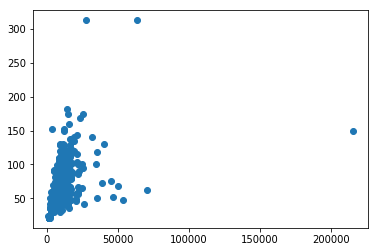

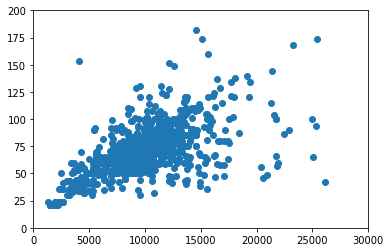

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [95]:
#Instead of just using the mean of LotFrontage, first let's take a look and see if there's any reasonable relation we can detect between LotArea and LotFrontage.
#We have all the LotArea data, so maybe we can use that to make better guesses about the missing frontage.

plt.scatter(train.LotArea, train.LotFrontage)
plt.show()

#Let's zoom in to get a better sense of what's happening away from the outliers
plt.scatter(train.LotArea, train.LotFrontage)
plt.xlim(0,30000)
plt.ylim(0,200)
plt.show()

#There's clearly a general trend upwards, but it's obviously still very noisy. It's probably not worth it at this point to try anything fancier than just using the mean
#Let's look at a summary of the LotFrontage data
train.LotFrontage.describe()

In [96]:
#Looks like the mean is 70 and the median is 69. A pretty nice distribution. Let's go ahead and replace the missing values with the mean (removing NaNs from the computation)

train.LotFrontage= train.LotFrontage.fillna(np.nanmean(train.LotFrontage))


In [97]:
#Now let's do a quick check for the other missing values, to see whether the NaNs just correspond to houses without the given features,
#so we can replace them with some definite 'none' category

#Again, we're missing
#* 8 entries about MasVnr,
#* about 40 entires about basements,
#* 1 entry in Electrical, which we'll handle on its own
#* around 80 entries about garages

#Count the houses with MasVnr
np.array((sum(train.MasVnrArea >0), sum(train.TotalBsmtSF>0), sum(train.GarageArea >0)))


array([ 591, 1423, 1379])

Looks like we're right about the Basement and Garage issues, the NaNs just correspond to houses without either basements or garages (in categorical variables), so we can just add a category for 'none'. Something else is going on with the Masonry Veneer, since only 591 houses are recorded as having more than 0 sqft Masonry Veneer, but 1452 houses are described as having a Masonry Veneer Type (and 8 are missing a type). Let's see what's going on with the houses that are missing the type.

In [98]:
train.loc[pd.isnull(train.MasVnrType)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,70.049958,7851,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,5,2010,WD,Normal,216500
529,530,20,RL,70.049958,32668,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.000000,8125,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,5,2008,WD,Normal,205950
936,937,20,RL,67.000000,10083,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,8,2009,WD,Normal,184900
973,974,20,FV,95.000000,11639,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,12,2008,New,Partial,182000
977,978,120,FV,35.000000,4274,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.000000,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.000000,9473,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,3,2008,WD,Normal,237000


In [99]:
train.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [100]:
#It looks like the MasVnrType field already inclues a 'None' category for those houses that don't have Masonry Veneer
#and the few house that are missing entries are also the houses missing entries in the MasVnrArea field.

#Since only 591 houses actually have Masonry Veneer, let's just assume the houses that don't have anything listed also don't have it,
#and we'll go ahead and fill out the MasVnrArea column with 0 and the MasVnrType column with 'None'

train.MasVnrArea = train.MasVnrArea.fillna(0)
train.MasVnrType = train.MasVnrType.fillna('None')

In [101]:
#Let's take a look at the house without Electrical data
train.loc[pd.isnull(train.Electrical)]

#Seems like a reasonable house: Built in 2006, remodeled in 2007, sold in 2008 for $167500. It has central air and all public Utilities. 
#It's doubtful that it just doesn't have electricity. We can just fill in the Electrical value with whatever the most common kind of Electrical is. 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,None,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,5,2008,WD,Normal,167500


In [102]:
#Take a look at our Electrical field
train.Electrical.describe()


count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

In [103]:
#The overwhelming majority of houses just have SBrkr - Standard Circuit Breakers & Romex, so let's go ahead and say this probably has the same. 
#In any case, if the Electrical data is so uniform it's quite doubtful that it will have an effect on the model we build. 

train.Electrical = train.Electrical.fillna('SBrkr')

Now let's just clean up the Garage and Basement issues. We'll replace the missing qualities with 'None'. 

In [104]:
#The basement fields that have NaNs are:
#BsmtQual
#BsmtCond
#BsmtExposure
#BsmtFinType1
#BsmtFinType2

#One thing we have to note is that 2 of the fields, BsmtExposure and BsmtFinType2 are missing 1 more entry than all the others 
#(and in fact, there are 1423 entries with non-zero basements, so at least one of these is missing these fields)
#For the other fields, we'll just fill the missing values in with 'None'
np.array((train.BsmtQual.unique(), train.BsmtCond.unique(), train.BsmtExposure.unique(), train.BsmtFinType1.unique(), train.BsmtFinType2.unique()))


array([array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object),
       array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object),
       array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object),
       array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object),
       array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)],
      dtype=object)

In [105]:
train.BsmtQual = train.BsmtQual.fillna('None')
train.BsmtCond = train.BsmtCond.fillna('None')
train.BsmtFinType1 = train.BsmtFinType1.fillna('None')

In [106]:
#Let's see the house that missing BsmtFinType2, but not BsmtFinType 1
train.loc[pd.isnull(train.BsmtFinType2) & (train.TotalBsmtSF>0)]

#It seems this house actually has almost all the basement information listed (it even an entry for BsmtExposure, so there's a different house that's missing that)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,10,2009,WD,Normal,284000


In [107]:
#Let's take a look at BsmtFinType2 to see what makes sense to fill in here
train.BsmtFinType2.describe()

count     1422
unique       6
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object

In [108]:
#It looks like the vast majority of houses with basements have BsmtFinType2 as 'Unfinished'
#That's a little weird, given that BsmtFinType2 is supposed to be the rating of basement *finished* area,
#but maybe it's just how they record unfinished sections of basement
#Let's check
sum((train.BsmtFinType2=='Unf') & (train.BsmtFinSF2<train.BsmtUnfSF))

#Ok, so actually most of the houses have 'Unfinished' BsmtFinType2, and and that doesn't actually count all the unfinished basement square footage.
#It seems like a weird way to do it, but that's fine.

1213

In [109]:
#In this case, it probably makes the most sense to go ahead and set the missing BsmtFinType2 to 'Unfinished' as well
train.loc[332,'BsmtFinType2'] = 'Unf'

#Let's take a look at the last missing basement data point
train.loc[pd.isnull(train.BsmtExposure) & (train.TotalBsmtSF>0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,65.0,14006,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,2,2006,WD,Normal,192500


In [110]:
#It look like this house has a totally unfinished basement, so let's go ahead and assume it also doesn't have basement exposure

train.loc[948, 'BsmtExposure'] = 'No'

In [111]:
#Now the rest of the BsmtFinType2 and BsmtExposure NaNs are just houses without basements, so we can go ahead and fill those in with the category 'None'

train.BsmtFinType2 = train.BsmtFinType2.fillna('None')
train.BsmtExposure = train.BsmtExposure.fillna('None')


In [112]:
#Let's take a last look at our data, and make sure the only remaining null entries are in our data on garages
train.info()

#Recall that we had 1379 houses with GarageArea greater than 0, so the missing values are just houses without garages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

In [113]:
#So, let's just fill in all the missing data with 'None'
#or, for GarageYrBlt, which is a number, lets use '0', as something out of the acceptable range (years in the Common Era) for garages to have been built.
#Presumably, more modern garages are worth more, so not having a garage should map onto roughly the same idea as having a very very very old one. 

#We'll fill the missing entries in the Year Built field with zeroes first
train.GarageYrBlt = train.GarageYrBlt.fillna(0)

#Now the only missing entries in the table at all are those in the garage fields under consideration, so we can just fill the rest of the table
train = train.fillna('None')

Beautiful! Our training data is nice and clean now. 

Now let's repeat all of that for the test data.

In [114]:
#Let's just repeat the steps we performed for cleaning our training data

#Drop the features that are mainly missing
real_test = real_test.drop(['MiscFeature', 'Fence', 'Alley','PoolQC', 'PoolArea'], axis = 1)

#Replace missing LotFrontage with the mean
real_test.LotFrontage= real_test.LotFrontage.fillna(np.nanmean(real_test.LotFrontage))
#Replace missing Fireplace data with new category 'None'
real_test.FireplaceQu =real_test.FireplaceQu.fillna('None')

#Replace missing Masonry Veneer data with 0 for Area dn 'None' for type
real_test.MasVnrArea = real_test.MasVnrArea.fillna(0)
real_test.MasVnrType = real_test.MasVnrType.fillna('None')


The basement data is messier for the test set. We have a house with a BasementQuality given, but no Basement Condition, and more houses with BasementFinishTypes. We'll need to dig in and see what's going on.

In [115]:
real_test.loc[pd.isnull(real_test.BsmtCond)&pd.notnull(real_test.BsmtQual)]

#It turns out we have 3 houses with Basements, but no BsmtCond given. Let's see what the most common basement conditions are 
#(given what we know about the condition of the rest of their basements) and fill in the missing values with that condition

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
580,2041,20,RL,103.0,16280,Pave,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,Ex,CBlock,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,Ex,Y,SBrkr,1671,0,0,1671,1.0,0.0,3,0,3,1,Ex,6,Typ,1,Gd,Attchd,1976.0,RFn,2.0,550.0,TA,TA,Y,280,90,0,0,0,0,5,2008,WD,Normal
725,2186,20,RL,65.0,6500,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,BrkFace,84.0,TA,TA,CBlock,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,TA,Y,SBrkr,1127,0,0,1127,0.0,1.0,1,1,3,1,TA,6,Typ,1,Po,Detchd,1991.0,Unf,2.0,480.0,TA,TA,Y,0,0,138,0,0,0,5,2008,WD,Normal
1064,2525,80,RL,72.0,9720,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,BrkFace,51.0,TA,TA,CBlock,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,TA,Y,SBrkr,1009,0,0,1009,0.0,0.0,2,0,3,1,TA,6,Typ,1,Fa,Detchd,1977.0,Unf,2.0,576.0,TA,TA,Y,0,0,0,0,0,0,6,2007,WD,Normal


In [116]:
#Check most common basement conditions for the situations of the missing houses
print(real_test.loc[(real_test.BsmtQual == 'Gd')&(real_test.BsmtFinType1=='GLQ')].BsmtCond.describe())
print(real_test.loc[(real_test.BsmtQual == 'TA')&(real_test.BsmtFinType1=='BLQ')].BsmtCond.describe())
print(real_test.loc[(real_test.BsmtQual == 'Gd')&(real_test.BsmtFinType1=='ALQ')].BsmtCond.describe())

count     278
unique      3
top        TA
freq      259
Name: BsmtCond, dtype: object
count     98
unique     3
top       TA
freq      89
Name: BsmtCond, dtype: object
count     79
unique     3
top       TA
freq      73
Name: BsmtCond, dtype: object


In [117]:
#In all cases, 'TA' is by far the most common Basement Condition. We'll fill in these missing values with 'TA'

real_test.loc[[580, 725, 1064],'BsmtCond'] = 'TA'

In [118]:
#We also have a house where no basement info is recorded
real_test.loc[pd.isnull(real_test.TotalBsmtSF)]

#Let's assume it doesn't have a basement, and set its basement square footage to 0
real_test.loc[660,'TotalBsmtSF'] =0
real_test.loc[660,'BsmtFinSF1'] =0
real_test.loc[660,'BsmtFinSF2'] =0
real_test.loc[660,'BsmtUnfSF'] =0

In [119]:
#For the houses without basements (i.e. TotalBsmtSF = 0), we'll set all the basement features to 'None'
real_test.loc[real_test.TotalBsmtSF==0,'BsmtQual']= real_test.loc[real_test.TotalBsmtSF==0].BsmtQual.fillna('None')
real_test.loc[real_test.TotalBsmtSF==0,'BsmtCond']= real_test.loc[real_test.TotalBsmtSF==0].BsmtCond.fillna('None')
real_test.loc[real_test.TotalBsmtSF==0,'BsmtExposure']= real_test.loc[real_test.TotalBsmtSF==0].BsmtExposure.fillna('None')
real_test.loc[real_test.TotalBsmtSF==0,'BsmtFinType1']= real_test.loc[real_test.TotalBsmtSF==0].BsmtFinType1.fillna('None')
real_test.loc[real_test.TotalBsmtSF==0,'BsmtFinType2']= real_test.loc[real_test.TotalBsmtSF==0].BsmtFinType2.fillna('None')

In [120]:
#Check what we're still missing
real_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 75 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

In [121]:
#Looks like there's still 2 missing BsmtQual and 2 missing BsmtExposure. Let's take a look

real_test.loc[pd.isnull(real_test.BsmtExposure) | pd.isnull(real_test.BsmtQual)]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
27,1488,20,RL,73.0,8987,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,5,2010,WD,Normal
757,2218,70,C (all),60.0,5280,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,None,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,7,2008,WD,Normal
758,2219,50,C (all),52.0,5150,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,5,2008,WD,Normal
888,2349,60,FV,81.0,10411,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,None,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,7,2007,New,Partial


In [122]:
#The two houses missing BsmtExposure *do* have basements (albeit unfinished).
#The 'None' category is meant for house without basments, so let's set these entries to 'No' (i.e. a basement with no exposure)
real_test.BsmtExposure = real_test.BsmtExposure.fillna('No')

In [123]:
#For the houses missing BsmtQual, let's fill them in with the most common Basement Quality for their basement condition (BsmtCond + totally unfinished)
print(real_test.loc[(real_test.BsmtCond=='Fa')&(real_test.BsmtUnfSF==real_test.TotalBsmtSF)].BsmtQual.describe())
print(real_test.loc[(real_test.BsmtCond=='TA')&(real_test.BsmtUnfSF==real_test.TotalBsmtSF)].BsmtQual.describe())

real_test.loc[757,'BsmtQual'] = 'TA'
real_test.loc[758,'BsmtQual'] = 'Gd'

count     27
unique     3
top       TA
freq      17
Name: BsmtQual, dtype: object
count     380
unique      4
top        Gd
freq      170
Name: BsmtQual, dtype: object


In [124]:
#We're also missing 2 entries for Basement bathrooms
real_test.loc[pd.isnull(real_test.BsmtHalfBath)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,4,2008,ConLD,Abnorml
728,2189,20,RL,123.0,47007,Pave,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,7,2008,WD,Normal


In [125]:
#These houses have no basements, so presumably they have no basement bathroom either. We'll set the values to 0
real_test.BsmtHalfBath = real_test.BsmtHalfBath.fillna(0)
real_test.BsmtFullBath = real_test.BsmtHalfBath.fillna(0)

Now we have the Garage fields to sort out. It looks like it's mainly just the 80 or so houses without garages, but there are two houses we have GarageType data for that we don't have any other garage info about, so let's look at those.

In [126]:
#Find the houses with extra GarageType data
real_test.loc[pd.notnull(real_test.GarageType)&pd.isnull(real_test.GarageCond)]

#It looks like one of them just doesn't have a garage. It must be an error in the collection that the type is Detached
#The other house has 360 sqft of garage, enough to fit 1 car, but we have no other information about the quality of the garage

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
666,2127,60,RM,57.0,8094,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,1000,9,2008,WD,Normal
1116,2577,70,RM,50.0,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,3,2007,WD,Alloca


In [127]:
# For the house without a garage, we'll just set the GarageArea to 0, and GarageType to 'None',
# and then when we sort out the whole batch of housese without garages we'll get the rest of the missing fields
real_test.loc[1116,'GarageArea'] = 0
real_test.loc[1116, 'GarageType'] ='None'

#For the other house, we'll just fill in the missing data with the most common values for those fields.
#For the year built, we'll assume the garage was built when the house was, since this is pretty common
print(real_test.GarageFinish.describe(), real_test.GarageQual.describe(), real_test.GarageCond.describe())

real_test.loc[666, 'GarageFinish'] = 'Unf'
real_test.loc[666, 'GarageQual'] = 'TA'
real_test.loc[666, 'GarageCond'] = 'TA'
real_test.loc[666, 'GarageYrBlt'] = real_test.loc[666,'YearBuilt']

count     1381
unique       3
top        Unf
freq       625
Name: GarageFinish, dtype: object count     1381
unique       4
top         TA
freq      1293
Name: GarageQual, dtype: object count     1381
unique       5
top         TA
freq      1328
Name: GarageCond, dtype: object


In [128]:
#Now for the houses without garages (i.e. GarageArea = 0), we'll set all the garage features to 'None'
real_test.loc[real_test.GarageArea==0,'GarageType']= real_test.loc[real_test.GarageArea==0].GarageType.fillna('None')
real_test.loc[real_test.GarageArea==0,'GarageFinish']= real_test.loc[real_test.GarageArea==0].GarageFinish.fillna('None')
real_test.loc[real_test.GarageArea==0,'GarageYrBlt']= real_test.loc[real_test.GarageArea==0].GarageYrBlt.fillna(0)
real_test.loc[real_test.GarageArea==0,'GarageQual']= real_test.loc[real_test.GarageArea==0].GarageQual.fillna('None')
real_test.loc[real_test.GarageArea==0,'GarageCond']= real_test.loc[real_test.GarageArea==0].GarageCond.fillna('None')
#There's one house with GarageCars missing. If it has no garage area, presumably it also has no garage space for cars.
real_test.loc[real_test.GarageArea==0,'GarageCars']= real_test.loc[real_test.GarageArea==0].GarageCars.fillna(0)

In [129]:
real_test.info()
#We still have a few missing values here and there. We'll just impute that the missing values are the most common for their columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 75 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

In [130]:
real_test.MSZoning.describe(), real_test.Utilities.describe(), real_test.Exterior1st.describe(), real_test.Exterior2nd.describe(), real_test.KitchenQual.describe(),
real_test.Functional.describe(), real_test.SaleType.describe()

real_test.loc[pd.isnull(real_test.MSZoning), 'MSZoning'] = real_test.loc[:,"MSZoning"].mode()[0]
real_test.loc[pd.isnull(real_test.Utilities), 'Utilities'] = real_test.loc[:,"Utilities"].mode()[0]
real_test.loc[pd.isnull(real_test.Exterior1st), 'Exterior1st'] = real_test.loc[:,"Exterior1st"].mode()[0]
real_test.loc[pd.isnull(real_test.Exterior2nd), 'Exterior2nd'] = real_test.loc[:,"Exterior2nd"].mode()[0]
real_test.loc[pd.isnull(real_test.KitchenQual), 'KitchenQual'] = real_test.loc[:,"KitchenQual"].mode()[0]
real_test.loc[pd.isnull(real_test.Functional), 'Functional'] = real_test.loc[:,"Functional"].mode()[0]
real_test.loc[pd.isnull(real_test.SaleType), 'SaleType'] = real_test.loc[:,"SaleType"].mode()[0]

Now all our data is shiny and clean. We have to convert our categorical variables into one-hot vectors, but we have to be careful since some categories only occur in the training set, so getting dummies variables for the test set won't create columns for those missing categories. 

In [131]:
#First, let's split off the target variable from the training data
target = train.loc[:,'SalePrice']
train = train.drop(['SalePrice'], axis=1)

#Second, concatenate the training and test sets
train_objs_num = len(train)
alldata = pd.concat(objs=[train, real_test], axis=0)

#Then, get dummy variables for the concatenations
alldata = pd.get_dummies(alldata, drop_first =1)

#Then, split the train and test parts back out
train_onehot = alldata[:train_objs_num]
test_onehot = alldata[train_objs_num:]
train_onehot = train_onehot.drop('Id', axis = 1)
test_onehot = test_onehot.drop('Id', axis = 1)

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_onehot, target, test_size=0.3, random_state=200)


OK. Let's start with something simple to get a baseline. 

Most of these variables probably will have little to no effect on the model. Before we go ahead and drop some that seem irrelevant, let's just see what we get when we use all of them. We'll need to convert our categorical variables into one-hot vectors. Since we're using all the variables at once, we shouldn't expect anthing particularly good. There wll end up being roughly 250 variables for only 1000 data points in our training set, so the model should be drastically overfit.


In [133]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [134]:
y_pred = linreg.predict(X_test)
print("The training score is", linreg.score(X_train, y_train))
print("The test score is", linreg.score(X_test, y_test))

The training score is 0.9457886637513591
The test score is 0.6103713995343543


Ooof. As expected, the model had enough degrees of freedom to hit the training data pretty accurately, but not in a way that would generalize at all well to data it wasn't allowed to see beforehand. We'll need to do some actual thinking to winnow our variables down to something reasonable. 

In [135]:
#We can actually do reasonably better if we first scalse our data (which has wildly different distributions for the different variables)
#and then use a regression method with some regularization
scaler = sk.preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(train_onehot)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, target, test_size=0.3, random_state=200)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 20, max_iter=1000, normalize = 0)
lasso.fit(X_train, y_train)

y_lasso_pred = lasso.predict(X_test)
print("The training score is", lasso.score(X_train, y_train))
print("The test score is", lasso.score(X_test, y_test))

The training score is 0.9340509449274425
The test score is 0.8091940697567472


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


That's already much better, and we haven't weeded out any cruft yet. Let's take look at coefficients from the model we just built, which will tell us which variables were most important in the model

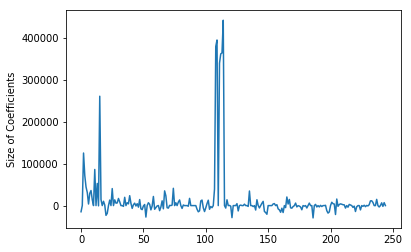

In [136]:
#Plot the coefficient of the Ridge model
plt.plot(lasso.coef_)
plt.ylabel('Size of Coefficients')
#plt.yscale('log')
plt.show()

In [137]:
#There are some clear outliers at the top end. Let's see which variables they correspond to.
print(np.nonzero(lasso.coef_>30000))
print(train_onehot.columns.values[(np.nonzero(lasso.coef_>30000))])

(array([  2,   3,   4,   5,   8,  11,  13,  15,  25,  67,  74, 107, 108,
       109, 111, 112, 113, 114, 135]),)
['LotArea' 'OverallQual' 'OverallCond' 'YearBuilt' 'BsmtFinSF1'
 'TotalBsmtSF' '2ndFlrSF' 'GrLivArea' 'GarageCars' 'Neighborhood_NoRidge'
 'Neighborhood_StoneBr' 'RoofStyle_Shed' 'RoofMatl_CompShg'
 'RoofMatl_Membran' 'RoofMatl_Roll' 'RoofMatl_Tar&Grv' 'RoofMatl_WdShake'
 'RoofMatl_WdShngl' 'Exterior2nd_ImStucc']


In [138]:
#Let's try building a model using the most important variables
important_coeffs = np.reshape(np.nonzero((lasso.coef_>5000)+(lasso.coef_<-5000) ),-1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_X[:,important_coeffs], target, test_size=0.3, random_state=200)

In [139]:
X_train2.shape

(1022, 109)

In [140]:
lasso_small = Lasso(alpha = 20, max_iter = 1000)
lasso_small.fit(X_train2, y_train2)

y_rid_pred = lasso_small.predict(X_test2)
print("The training score is", lasso_small.score(X_train2, y_train2))
print("The test score is", lasso_small.score(X_test2, y_test2))

The training score is 0.9309333211393626
The test score is 0.8035621964840399


In [141]:
#We're doing alright so far with these lasso models, but alpha = 20 was just a stab in the dark. To choose the parameters more efficiently,
#let's use a grid search algorithm to test multiple options at once

from sklearn.model_selection import GridSearchCV

#We set up the hyperparameter grid
alpha_space = np.arange(100, 500, 25)
#normalizers = np.array((0,1))
#max_iter = np.array((1000,10000))

param_grid = {'alpha': alpha_space}

# Use a Lasso regressor
lassoreg = Lasso()

# Build the GridSearchCV 
lassoreg_cv = GridSearchCV(lassoreg, param_grid, cv=5)

# Fit it to the data. GridSearchCV does the k-fold cross validation itself, so we don't need to use our train-test split data,
#instead we can give it all our training data
lassoreg_cv.fit(scaled_X, target)

# Print the tuned parameters and score
print("Tuned Regression Parameters: {}".format(lassoreg_cv.best_params_)) 
print("Best score is {}".format(lassoreg_cv.best_score_))

Tuned Regression Parameters: {'alpha': 150}
Best score is 0.8505250021762462


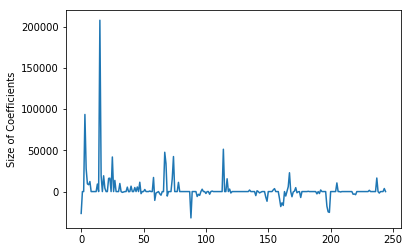

In [142]:
#Looks like the best alpha value we found is 150, which is much bigger than 20. It seems to produce a much better fit to the data as well.
#Here we don't have a cross-validation set kept separate for getting results, but the models buuilt by the grid search are cross-validated against data
#that is withheld from each one. The best model that is eventually chosen then reports its score on the whole data set, but because it wasn't trained on 
#the whole set we shouldn't worry too much about overfitting


#Let's see what the distribution of coefficients looks like. This tells us which variables the model assigns more weight to. 
best_coeffs = lassoreg_cv.best_estimator_.coef_

#Plot the coefficient of the Ridge model
plt.plot(best_coeffs)
plt.ylabel('Size of Coefficients')
#plt.yscale('log')
plt.show()

In [143]:
print(sum(best_coeffs !=0))

print(train_onehot.columns.values[best_coeffs !=0])

93
['MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MasVnrArea' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'WoodDeckSF' 'ScreenPorch'
 'MoSold' 'YrSold' 'MSZoning_RL' 'MSZoning_RM' 'LotShape_IR2'
 'LandContour_HLS' 'LandContour_Lvl' 'LotConfig_CulDSac' 'LotConfig_FR2'
 'LandSlope_Mod' 'Neighborhood_BrkSide' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 'Neighborhood_IDOTRR'
 'Neighborhood_Mitchel' 'Neighborhood_NAmes' 'Neighborhood_NWAmes'
 'Neighborhood_NoRidge' 'Neighborhood_NridgHt' 'Neighborhood_OldTown'
 'Neighborhood_Somerst' 'Neighborhood_StoneBr' 'Condition1_Norm'
 'Condition2_PosN' 'BldgType_Duplex' 'BldgType_Twnhs' 'BldgType_TwnhsE'
 'HouseStyle_1Story' 'HouseStyle_2Story' 'RoofStyle_Gable' 'RoofStyle_Hip'
 'RoofMatl_WdShngl' 'Exterior1st_BrkFace' 'Exterior1st_CemntBd'
 'Exterior1st_HdBoard' 'Exterior1st_MetalSd' 'Exterior2nd_ImStucc'
 'Exterior2nd_Stucco' 'Exterior2nd_Vin

In [144]:
#Let's try training a model to only focus of those coefficients

#First, split the data up
important_coeffs = np.reshape(np.nonzero(best_coeffs !=0),-1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(scaled_X[:,important_coeffs], target, test_size=0.3, random_state=200)

In [145]:
#Train a lasso model on the reduced feature collection

lasso_smaller = Lasso(alpha = 150, max_iter = 1000)
lasso_smaller.fit(X_train3, y_train3)

y_rid_pred = lasso_smaller.predict(X_test3)
print("The training score is", lasso_smaller.score(X_train3, y_train3))
print("The test score is", lasso_smaller.score(X_test3, y_test3))

The training score is 0.8844832185992674
The test score is 0.857457541839003


In [146]:
#Submit our predictions with the GridSearched model
scaled_test = scaler.fit_transform(test_onehot)
test_submission = lassoreg_cv.predict(scaled_test)
d = {'Id': real_test.Id, 'SalePrice': test_submission}
submission = pd.DataFrame(data=d)
submission.to_csv('submission2.csv', index = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [147]:
#Submit our predictions with the reduced-variable model
scaled_test = scaler.fit_transform(test_onehot)
test_submission = lasso_smaller.predict(scaled_test[:,important_coeffs])
d = {'Id': real_test.Id, 'SalePrice': test_submission}
submission = pd.DataFrame(data=d)
submission.to_csv('submission3.csv', index = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [148]:
#Let's try running the parameter search on the reduced set of features
# Setup the hyperparameter grid
alpha_space = np.arange(10, 100, 5)
#normalizers = np.array((0,1))
#max_iter = np.array((1000,10000))

param_grid = {'alpha': alpha_space}

#Set up the grid search
lassoreg = Lasso()
lassoreg_cv = GridSearchCV(lassoreg, param_grid, cv=5)

# Fit it to the data
lassoreg_cv.fit(scaled_X[:,important_coeffs], target)

# Print the tuned parameters and score
print("Tuned Regression Parameters: {}".format(lassoreg_cv.best_params_)) 
print("Best score is {}".format(lassoreg_cv.best_score_))

Tuned Regression Parameters: {'alpha': 75}
Best score is 0.8625578936701384


In [149]:
#Submit our predictions for the new grid search on reduced feature model
scaled_test = scaler.fit_transform(test_onehot)
test_submission = lassoreg_cv.predict(scaled_test[:,important_coeffs])
d = {'Id': real_test.Id, 'SalePrice': test_submission}
submission = pd.DataFrame(data=d)
submission.to_csv('submission4.csv', index = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Alright, let's turn to XGBoost, and see if we can get better results with a beefier algorithm.

In [150]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [151]:
#And let's run the XGBregressor on our reduced feature set, X_train3 and y_train3

xgb.fit(X_train3, y_train3)

y_xgb_pred = xgb.predict(X_test3)
print("The training score is", xgb.score(X_train3, y_train3))
print("The test score is", xgb.score(X_test3, y_test3))




The training score is 0.9935131329931075
The test score is 0.899720021415571


Very nice result. Test score of almost 90%. Let's get some predictions and submit. 

In [152]:
#Submit our predictions for the XGBregressor model
scaled_test = scaler.fit_transform(test_onehot)
test_submission = xgb.predict(scaled_test[:,important_coeffs])
d = {'Id': real_test.Id, 'SalePrice': test_submission}
submission = pd.DataFrame(data=d)
submission.to_csv('submission5.csv', index = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


We're doing much better, but we haven't optimized our XGB regressor at all yet. Let's take a search through the parameter space and see if we can do better.

In [154]:
#xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           #colsample_bytree=1, max_depth=7)


# Setup the hyperparameter grid
estimator_range = np.arange(100,300,50)
max_depth_range = np.arange(3,8,1)
learning_rate_range = (0.3,0.5,0.7, 0.8)


#'n_estimators': estimator_range, 'learning_rate': learning_rate_range, 'max_depth':max_depth_range, 
param_grid = {'n_estimators':estimator_range,'max_depth':max_depth_range, 'learning_rate' : learning_rate_range}

#Set up the grid search
xgb = xgboost.XGBRegressor(subsample=.75, gamma=0, colsample_bytree=1)
xgb_cv = GridSearchCV(xgb, param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(scaled_X[:,important_coeffs], target)

# Print the tuned parameters and score
print("Tuned Regression Parameters: {}".format(xgb_cv.best_params_)) 
print("Best score is {}".format(xgb_cv.best_score_))

Tuned Regression Parameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}
Best score is 0.8746953726912744


In [155]:
scaled_test = scaler.fit_transform(test_onehot)
test_submission = xgb_cv.predict(scaled_test[:,important_coeffs])
d = {'Id': real_test.Id, 'SalePrice': test_submission}
submission = pd.DataFrame(data=d)
submission.to_csv('submission6.csv', index = 0)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
